# PCM development notebook

The aim of this notebook is to create a PCM model and train it with a dataset. Some figures that could help to PCM model development are also plotted.
__TODO__: explain more (pyxpcm, where to find some exemples of models or datasets) and logos 

In [14]:
import xarray as xr
import numpy as np

import pyxpcm
from pyxpcm.models import pcm

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

import Plotter
from Plotter import Plotter #new class for plots in pyxpcm

from PIL import Image

import importlib

import concurrent.futures
from tqdm import tqdm

## User input
***

__Choose dataset__

In [2]:
#### file path ####

# GLOBAL-ANALYSIS-FORECAST-PHY-001-024
#file_path = '/export/home1/agarciaj/datasets/global-analysis-forecast-phy-001-024_1598520725098.nc'

# GLOBAL_REANALYSIS_PHY_001_030
#file_path = '/export/home1/agarciaj/datasets/global-reanalysis-phy-001-030-monthly_1600874641188_caribe.nc'
file_path = '/export/home1/agarciaj/datasets/global-reanalysis-phy-001-030-monthly_1601036810235.nc'

# GLOBAL_REANALYSIS_PHY_001_031
#file_path = '/export/home1/agarciaj/datasets/global-reanalysis-phy-001-031-grepv2-monthly_1598972586332.nc'

# GLOBAL_REANALYSIS_BIO_001_029
#file_path = '/export/home1/agarciaj/datasets/global-reanalysis-bio-001-029-monthly_1598524945308.nc'

Variables names in dataset (__TODO__: find an elegant way to do that)

In [3]:
# time and coordinates dimensions (expecify then here but use a generic name in the rest of the notebook)
time_dim = 'time'
lon_dim = 'longitude'
lat_dim = 'latitude'
z_dim = 'depth'
var_name = 'thetao' #temp_var = 'fe'

__Model options__

In [4]:
#Choise of z and pcm features (very important to make a good choise) 
z = np.arange(-1.,-2000,-10.)
pcm_features = {'temperature': z} #pcm_features = {'iron': z}
# {variable name in model: variable name in dataset}
features_in_ds = {'temperature': var_name}

# number of classes
K=6

__Plot options__

## Load training dataset
***

In [ ]:
ds = xr.open_dataset(file_path)

#some format
ds['depth'] = -np.abs(ds['depth'].values)
ds.depth.attrs['axis'] = 'Z'

ds

Quick plot of dataset

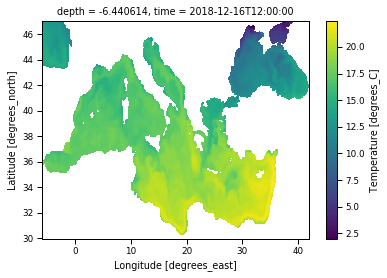

In [6]:
ds[var_name].isel(time=11, depth=5).plot();

## Create and train model
***

### Create PCM

In [7]:
#z choise
z = ds['depth'][0:20]
pcm_features = {'temperature': z}

m = pcm(K=K, features=pcm_features)
m

<pcm 'gmm' (K: 6, F: 1)>
Number of class: 6
Number of feature: 1
Feature names: odict_keys(['temperature'])
Fitted: False
Feature: 'temperature'
	 Interpoler: <class 'pyxpcm.utils.Vertical_Interpolator'>
	 Scaler: 'normal', <class 'sklearn.preprocessing._data.StandardScaler'>
	 Reducer: True, <class 'sklearn.decomposition._pca.PCA'>
Classifier: 'gmm', <class 'sklearn.mixture._gaussian_mixture.GaussianMixture'>

### Fit Model

In [8]:
m.fit_predict(ds, features=features_in_ds, dim=z_dim, inplace=True)
m

<pcm 'gmm' (K: 6, F: 1)>
Number of class: 6
Number of feature: 1
Feature names: odict_keys(['temperature'])
Fitted: True
Feature: 'temperature'
	 Interpoler: <class 'pyxpcm.utils.Vertical_Interpolator'>
	 Scaler: 'normal', <class 'sklearn.preprocessing._data.StandardScaler'>
	 Reducer: True, <class 'sklearn.decomposition._pca.PCA'>
Classifier: 'gmm', <class 'sklearn.mixture._gaussian_mixture.GaussianMixture'>
	 log likelihood of the training set: 43.253159

## Development plots
***

#### __1. Scatter plot of features, as seen by the classifier__

__TODO__: Plot only first dimension for each feature

In [ ]:
g = m.plot.preprocessed(ds, features=features_in_ds, style='darkgrid', dim=z_dim)

In [ ]:
g = m.plot.preprocessed(ds, features=features_in_ds, kde=True, dim=z_dim)

#### __2. Mask__

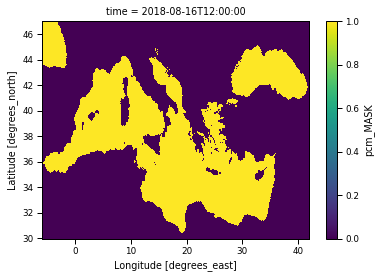

In [9]:
mask = ds.isel(time=7).pyxpcm.mask(m, features=features_in_ds, dim=z_dim)
mask.plot()

#### __3. BIC__

remapping function 

In [10]:
#function remapping grid using start point and grid extent

def mapping_corr_dist(coor_dist, start_point, grid_extent):

    # angular distance d/earth's radius (km)
    delta = coor_dist/6371
    
    # all in radians (conversion at the end)
    grid_extent = grid_extent*np.pi/180
    start_point = start_point*np.pi/180
    
    ### while loop for lat nord ###
    max_lat = grid_extent[3]
    lat2 = -np.pi/2 
    lat1 = start_point[1]
    # bearing = 0 donc cos(0)=1 and sin(0)=0
    new_lats = [lat1]
    while lat2 < max_lat:
        lat2 = np.arcsin(np.sin(lat1)*np.cos(delta) + np.cos(lat1)*np.sin(delta))
        new_lats.append(lat2)
        lat1 = lat2

        
    ### while loop for lat sud ###
    min_lat = grid_extent[2]
    lat2 = np.pi/2 
    lat1 = start_point[1]
    # bearing = pi donc cos(pi)=-1 and sin(pi)=0
    while lat2 > min_lat:
        lat2 = np.arcsin(np.sin(lat1)*np.cos(delta) - np.cos(lat1)*np.sin(delta))
        new_lats.append(lat2)
        lat1 = lat2
    
    new_lats = np.sort(new_lats)*180/np.pi
    
    ### while loop for lon east ###
    max_lon = grid_extent[1]
    lon2 = -np.pi
    lon1 = start_point[0]
    lat1 = start_point[1]
    # bearing = pi/2 donc cos(pi/2)=0 and sin(pi/2)=1
    new_lons = [lon1]
    dlon = np.arctan2(np.sin(delta)*np.cos(lat1), np.cos(delta)-np.sin(lat1)*np.sin(lat1))
    while lon2 < max_lon:
        lon2 = lon1 + dlon
        new_lons.append(lon2)
        lon1 = lon2
        
    ### while loop for lon west ###
    min_lon = grid_extent[0]
    lon2 = np.pi
    lon1 = start_point[0]
    lat1 = start_point[1]
    # bearing = -pi/2 donc cos(-pi/2)=0 and sin(-pi/2)=-1
    dlon = np.arctan2(-np.sin(delta)*np.cos(lat1), np.cos(delta)-np.sin(lat1)*np.sin(lat1))
    while lon2 > min_lon:
        lon2 = lon1 + dlon
        new_lons.append(lon2)
        lon1 = lon2
        
    new_lons = np.sort(new_lons)*180/np.pi
    
    return new_lats, new_lons

__User input__

In [11]:
corr_dist = 50
Nrun = 10
NK = 20
#only one time step
dsp = ds.isel(time=9)

Calculation using paralelisation

In [15]:
#start = time.time()

# grid extent
grid_extent = np.array([ds.longitude.values.min(), ds.longitude.values.max(), ds.latitude.values.min(), ds.latitude.values.max()])

class_list = np.arange(0,NK) # this is the list of arguments to iterate over, for instance nb of classes for a PCM

def BIC_cal(X, k):
    """ Function to run on a single argument """
    
    #create model
    m = pcm(K=k+1, features=pcm_features)
    #fit model
    m._classifier.fit(X)
    
    #calculate LOG LIKEHOOD
    llh = m._classifier.score(X)

    # calculate Nb of independant parameters to estimate
    # we suppose m._classifier.covariance_type == 'full'
    _, n_features = m._classifier.means_.shape
    cov_params = m._classifier.n_components * n_features * (n_features + 1) / 2.
    mean_params = n_features * m._classifier.n_components
    Nf = int(cov_params + mean_params + m._classifier.n_components - 1)
    
    #calculate bic
    N_samples = X.shape[0]
    BIC = (-2 * llh * N_samples + Nf * np.log(N_samples))
    #BIC = m._classifier.bic(X)
    
    return BIC, k 

BIC = np.zeros((NK,Nrun)) 
#BIC = []
for run in range(Nrun):
    #print('run=' + str(run))
    
    #random fist point
    latp = np.random.choice(dsp.latitude.values, 1, replace=False)
    lonp = np.random.choice(dsp.longitude.values, 1, replace=False)
    #mapping
    new_lats, new_lons = mapping_corr_dist(coor_dist=corr_dist, start_point=np.concatenate((lonp,latp)), grid_extent=grid_extent)
    ds_ran = dsp.sel(latitude=list(new_lats), longitude=list(new_lons), method='nearest')
    
    # pre-processing
    m = pcm(K=4, features=pcm_features)
    X , sampling_dims = m.preprocessing(ds_ran, features=features_in_ds, dim=z_dim, action='fit')
    
    #BIC computation in parallel
    results = []
    ConcurrentExecutor = concurrent.futures.ThreadPoolExecutor(max_workers=100)
    with ConcurrentExecutor as executor:
        future_to_url = {executor.submit(BIC_cal, X, k): k for k in class_list}
        futures = concurrent.futures.as_completed(future_to_url)
        futures = tqdm(futures, total=len(class_list))
        for future in futures:
            traj = None
            try:
                traj = future.result()
            except Exception as e:
                #pass
                raise
            finally:
                results.append(traj)
    results = [r for r in results if r is not None]  # Only keep non-empty results
    results.sort(key=lambda x:x[1])
    BIC[:,run] = np.array([i[0] for i in results])
    
#end = time.time()
#print((end - start)/60)

100%|██████████| 20/20 [00:30<00:00,  1.53s/it]


*PLOT*

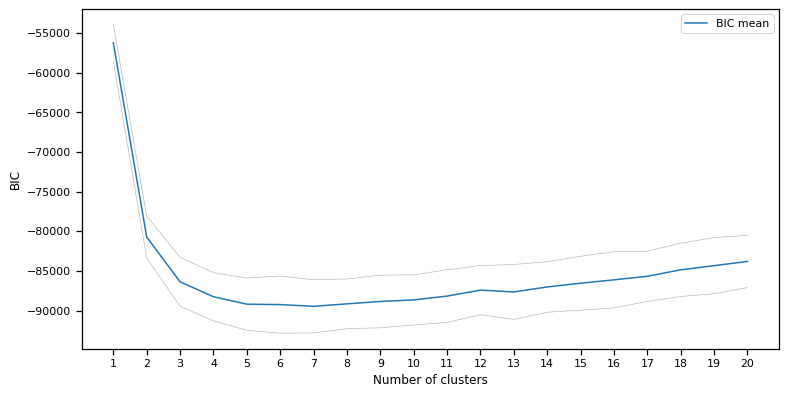

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5), dpi=90)
BICmean = np.mean(BIC,axis=1)
BICstd = np.std(BIC,axis=1)
normBICmean = (BICmean-np.mean(BICmean))/np.std(BICmean)
normBICstd = np.std(normBICmean)
#plt.plot(np.arange(kmax)+1,(BIC-np.mean(BIC))/np.std(BIC),label='Raw BIC')
plt.plot(np.arange(NK)+1,BICmean,label='BIC mean')
plt.plot(np.arange(NK)+1,BICmean+BICstd,color=[0.7]*3,linewidth=0.5)
plt.plot(np.arange(NK)+1,BICmean-BICstd,color=[0.7]*3,linewidth=0.5)
plt.ylabel('BIC')
plt.xlabel('Number of clusters')
plt.xticks(np.arange(NK)+1)
plt.legend()

__Number of classes to be used:__

In [19]:
op_classes = np.argmin(BICmean)+1
op_classes

7

#### __4. Robustness__

Description

In [ ]:
m.fit(ds, features=features_in_ds, dim=z_dim);
m.predict_proba(ds, features=features_in_ds, dim=z_dim, inplace=True);
ds.pyxpcm.robustness(m, inplace=True)
ds.pyxpcm.robustness_digit(m, inplace=True)

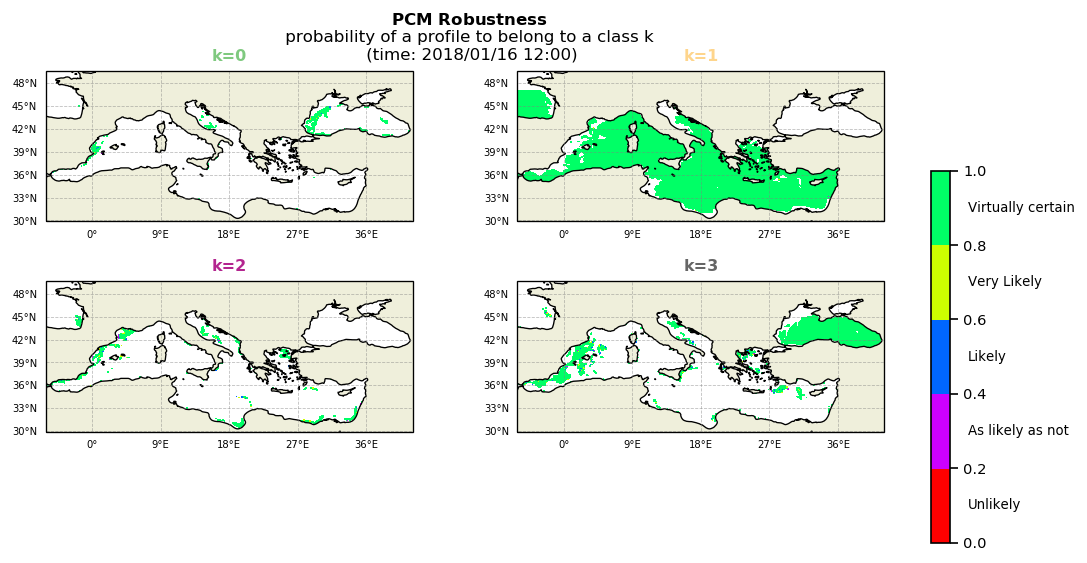

In [24]:
P = Plotter(ds, m)
P.plot_robustness(time_slice="2018-01-01")

## Save fitted model
***

In [ ]:
# save model to development
#m.to_netcdf('models/tests_model_GLOBAL_REANALYSIS_PHY_001_030_temp.nc')